# Проектная работа

## Инструкция по выполнению проекта:

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

## Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

In [1]:
# Импортируем модули, которые понадобятся по ходу работы
import pandas as pd
pd.set_option('display.float_format', '{:,.3f}'.format)
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

## Загрузите данные и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [2]:
# Функция для для обработки таблицы и получения информации о ней

def get_table_info(table):
    print(f'Информация о таблице {table.name}:')
    table.columns = [x.lower().replace(' ', '_') for x in table.columns.values]
    table = table.drop_duplicates().reset_index(drop=True)
    display(table.head(3))
    table.info()
    print()

In [3]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
visits.name = 'visits'
orders = pd.read_csv('/datasets/orders_info_short.csv')
orders.name = 'orders'
costs = pd.read_csv('/datasets/costs_info_short.csv')
costs.name = 'costs'

In [4]:
get_table_info(visits)

Информация о таблице visits:


,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null object
session_end      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB



Необходимо изменить тип столбцов с данными о времени на datetime:

In [5]:
for col in ['session_start', 'session_end']:
    visits[col] = pd.to_datetime(visits[col])

In [6]:
get_table_info(orders)

Информация о таблице orders:


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.990
1,174361394180,2019-05-01 12:24:04,4.990
2,529610067795,2019-05-01 11:34:04,4.990


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null object
revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB



In [7]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [8]:
get_table_info(costs)

Информация о таблице costs:


,dt,channel,costs
0,2019-05-01,FaceBoom,113.300
1,2019-05-02,FaceBoom,78.100
2,2019-05-03,FaceBoom,85.800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB



In [9]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

### Вывод
В разделе данные были подготовлены анализу: исправлены названия столбцов согласно принятому стилю и изменены типы столбцов, содержащих информацию о времени, на datetime.

## Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

### Функции расчета
#### Функция создания профилей пользователей

In [10]:
# Функция для создания профилей пользователей

def get_profiles(sessions, orders, ad_costs):
    # Шаг 1. Передадим в функцию расчета профиля данные о рекламных затратах (фрейм ad_costs)
    
    # сортируем сессии по id пользователя и дате для того,чтобы работал first
    # находим первые значения для параметров пользователя - будем считать их основными 
    profiles = (sessions.sort_values(by = ['user_id', 'session_start'])           
                        .groupby('user_id').agg({'session_start' : 'first',       
                                                 'channel': 'first',
                                                 'device': 'first',
                                                 'region': 'first'})                                 
                        .rename(columns = {'session_start' : 'first_ts'})  
                        .reset_index()  # вернем все данные из индекса в колонки                                           
               )
    # определим дату первого посещеня 
    # и начало месяца первого посещения - они понадобятся нам при когортном анализе
    profiles['dt'] = profiles['first_ts'].dt.date                                 
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')     
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())   
            
    # Шаг 2. К данным о рекламных затратах добавим количества привлеченных пользователей
    new_users = profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(
        columns = {'user_id': 'unique_users'}).reset_index()
    ad_costs = ad_costs.merge(new_users, on = ['dt', 'channel'], how = 'left')
    
    # Шаг 3. Найдем среднюю стоимость привлечения пользователя
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # Шаг 4. Присоединим данные к профилям пользователей информацию о средней стоимости привлечения в
    # день привлечения пользователя из нужного источника
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on = ['dt', 'channel'], how = 'left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0) # органические пользователи будут стоить 0
    
    return profiles

#### Функция расчета LTV и ROI

In [11]:
# Функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функция расчета удержания

In [12]:
# Функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция расчета конверсии

In [13]:
# Функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функции визуализации
#### Функция сглаживания фрейма

In [14]:
# Функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Функция визуализации удержания

In [15]:
# Функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### Функция визуализации конверсии

In [16]:
# Функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Функция визуализации LTV и ROI

In [17]:
# Функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Вывод
В разделе заданы функции для создания профилей пользователей, расчета и анализа LTV, ROI, удержания и конверсии, а так же для визуализации всего вышеперечисленного.

## Проведите исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [18]:
# Строим профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.231


In [19]:
# Минимальная дата привлечения пользователей
print('Минимальная дата привлечения пользователей:', profiles['dt'].min())
# Максимальная дата привлечения пользователей
print('Максимальная дата привлечения пользователей:', profiles['dt'].max())

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


### Страны

In [20]:
# Функция для выделения самых популярных значений столбца
def top_list(column):    
    top_table = (profiles.groupby(column)
                 .agg({'user_id': 'nunique', 'payer': 'mean'})
                 .sort_values(by = 'payer', ascending = False)
                 .rename(columns = {'user_id': 'User Count', 'payer': 'Payers %'}))
    display(top_table)
    (top_table.reset_index().set_index(column)
     .plot(kind = 'pie', y = 'User Count', autopct = '%1.1f%%', figsize = (6,6),
           legend = False, startangle = 45, title = column))

Страны, откуда приходят посетители:


,User Count,Payers %
region,,
United States,100002,0.069
Germany,14981,0.041
UK,17575,0.040
France,17450,0.038


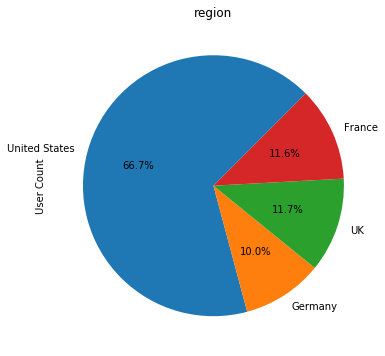

In [21]:
print('Страны, откуда приходят посетители:')
top_list('region')

Пользователи приходят из США, Франции, Германии и Великобритании. Больше всего платящих пользователей приходит из США (почти 7%), остальные страны приносят примерное одинаковое количество платящих пользователей (около 4%).

### Устройства

Список устройств пользователей:


,User Count,Payers %
device,,
Mac,30042,0.064
iPhone,54479,0.062
Android,35032,0.059
PC,30455,0.050


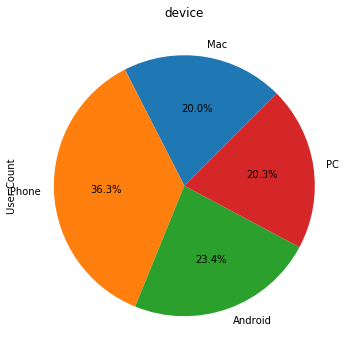

In [22]:
print('Список устройств пользователей:')
top_list('device')

Пользователи имеют следующие платформы: iPhone, Android, Mac и PC. Большая часть из платящих пользователей имеет Mac (6,3%) или iPhone (6,2%).

### Каналы

Пользователи приходили из следующих рекламных каналов:


,User Count,Payers %
channel,,
FaceBoom,29144,0.122
AdNonSense,3880,0.113
lambdaMediaAds,2149,0.105
TipTop,19561,0.096
RocketSuperAds,4448,0.079
WahooNetBanner,8553,0.053
YRabbit,4312,0.038
MediaTornado,4364,0.036
LeapBob,8553,0.031


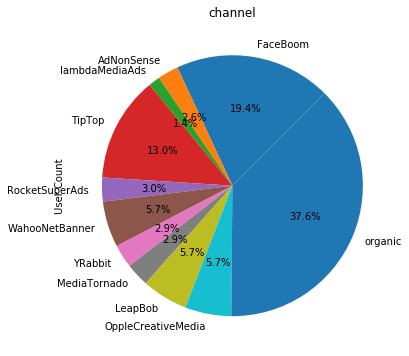

In [23]:
print('Пользователи приходили из следующих рекламных каналов:')
top_list('channel')

Выше представлен список каналов привлечения пользователей (всего 11 штук) и круговая диаграмма их распределения. Больше всего платящих пришло из FaceBoom (12,2%), AdNonSense (11,3%) и lambdaMediaAds (10,4%).

### Вывод
* Пользователи приходят из США, Франции, Германии и Великобритании. Больше всего платящих - из США (6.9%);
* Пользователи заходят со следующих платформ: iPhone, Android, Mac и PC. Самый большой процент платящих пользователей - на Mac (6.3%);
* Пользователи переходят с 11 каналов. Больше всего платящих пришло из FaceBoom (12.2%);
* Лучшую конверсию в покупателей имеют пользователи с техникой Apple;
* Большая часть пользователей заходит с мобильных устройств.

## Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### Количество потраченных денег

In [24]:
print(f'Всего потрачено {"%.2f" % profiles["acquisition_cost"].sum()}$.')

Всего потрачено 105497.30$.


In [25]:
print('Общее количество потраченных денег в разбивке по источникам:')
(profiles[profiles['channel'] != 'organic']
 .pivot_table(index = 'channel', values = 'acquisition_cost', aggfunc = 'sum')
 .sort_values(by = 'acquisition_cost')
 .rename(columns = {'acquisition_cost': 'Рекламный бюджет, $'}))

Общее количество потраченных денег в разбивке по источникам:


,"Рекламный бюджет, $"
channel,
YRabbit,944.220
MediaTornado,954.480
lambdaMediaAds,"1,557.600"
LeapBob,"1,797.600"
RocketSuperAds,"1,833.000"
OppleCreativeMedia,"2,151.250"
AdNonSense,"3,911.250"
WahooNetBanner,"5,151.000"
FaceBoom,"32,445.600"


Реклманый бюджет в разбивке по источникам и дням:


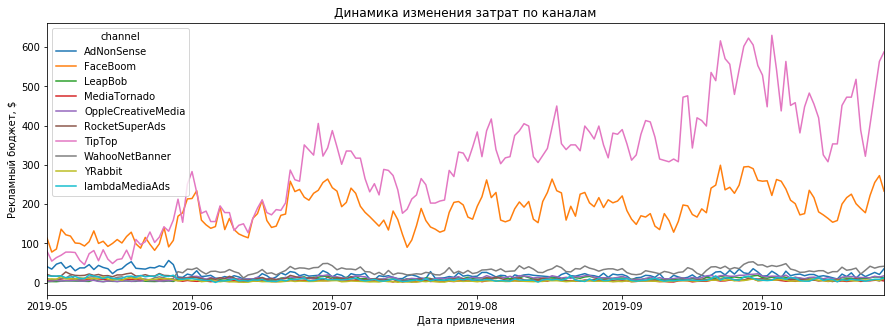

In [26]:
# Смотрим динамику изменения стоимости привлечения по источникам и дням

print('Реклманый бюджет в разбивке по источникам и дням:')
(profiles[profiles['channel'] != 'organic']
 .pivot_table(index = 'dt', columns = 'channel', values = 'acquisition_cost', aggfunc = 'sum')
 .plot(figsize = (15,5)))
plt.ylabel('Рекламный бюджет, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика изменения затрат по каналам')
plt.show()

Реклманый бюджет в разбивке по источникам и месяцам:


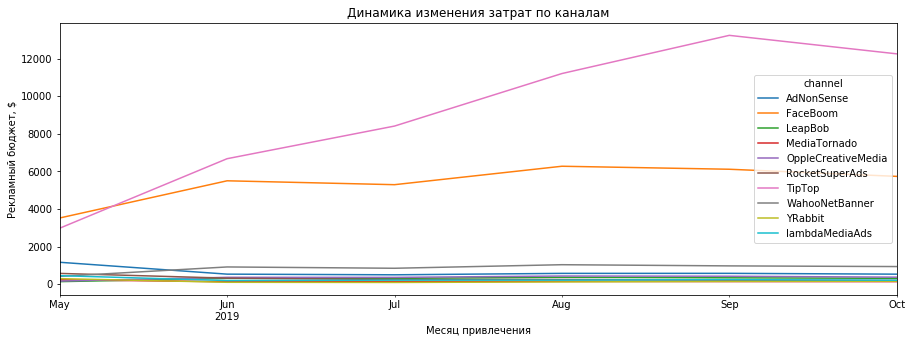

In [27]:
# Смотрим динамику изменения стоимости привлечения по источникам и месяцам

print('Реклманый бюджет в разбивке по источникам и месяцам:')
(profiles[profiles['channel'] != 'organic']
 .pivot_table(index = 'month', columns = 'channel', values = 'acquisition_cost', aggfunc = 'sum')
 .plot(figsize = (15,5)))
plt.ylabel('Рекламный бюджет, $')
plt.xlabel('Месяц привлечения')
plt.title('Динамика изменения затрат по каналам')
plt.show()

### Средняя стоимость покупателя

In [28]:
# Считаем среднюю стоимость привлечения покупателя для каждого канала

(profiles[profiles['channel'] != 'organic']
 .pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
 .rename(columns = {'acquisition_cost': 'CAC mean, $'})
 .sort_values(by = 'CAC mean, $', ascending = False))

,"CAC mean, $"
channel,
TipTop,2.799
FaceBoom,1.113
AdNonSense,1.008
lambdaMediaAds,0.725
WahooNetBanner,0.602
RocketSuperAds,0.412
OppleCreativeMedia,0.250
YRabbit,0.219
MediaTornado,0.219


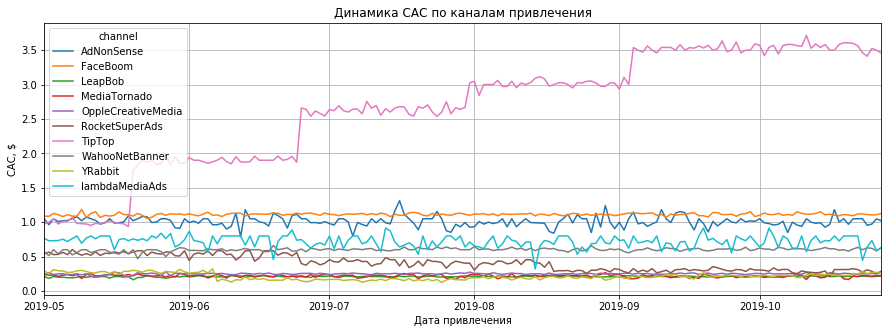

In [29]:
# Строим график истории изменений CAC по каналам привлечения

(profiles[profiles['channel'] != 'organic']
 .pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='mean')
 .plot(grid=True, figsize=(15, 5)))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

In [30]:
print(f"Среднее значение CAC по всему проекту составляет ${'%.2f' % profiles[profiles['channel'] != 'organic']['acquisition_cost'].mean()}.")

Среднее значение CAC по всему проекту составляет $1.13.


### Вывод
Видно, что самыми дорогими каналами привлечения были TipTop (средняя стоимость 2.8 долларов) и FaceBoom (1.11 долларов).
CAC для канала TipTop со временем значительно выросла.
Среднее значение CAC по всему проекту составляет $1.13.

## Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

In [42]:
observation_date = datetime(2019, 11, 1).date() # Момент анализа
horizon_days = 14 # Горизонт анализа 
profiles = profiles.query('channel != "organic"') # Удаляем органических пользователей

### Проанализируйте общую окупаемость рекламы

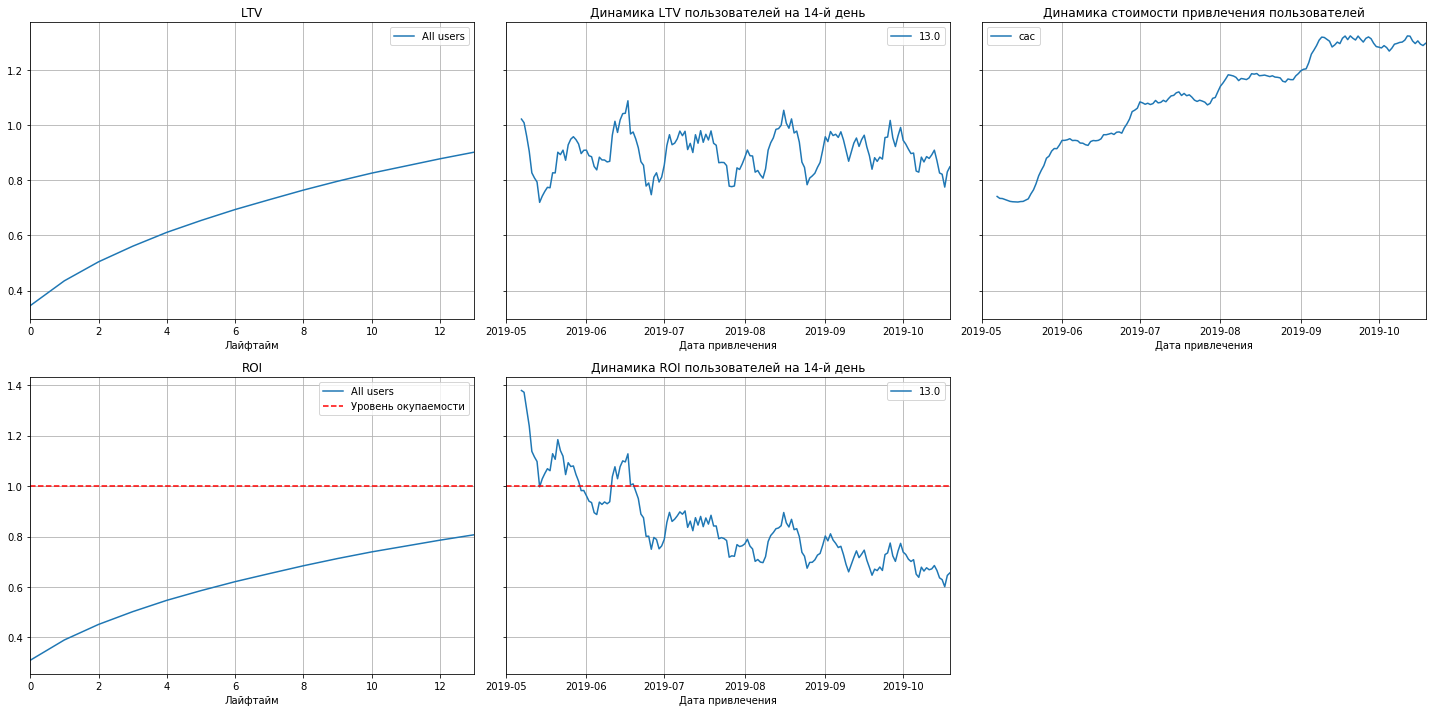

In [32]:
# Считаем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# Строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
* Реклама не окупается. ROI в конце двух недель — около 80%.
* CAC не стабилен и постоянно растет. Скорее всего, дело в увеличении рекламного бюджета источника TipTop.
* На LTV влияет сезонный фактор, но этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

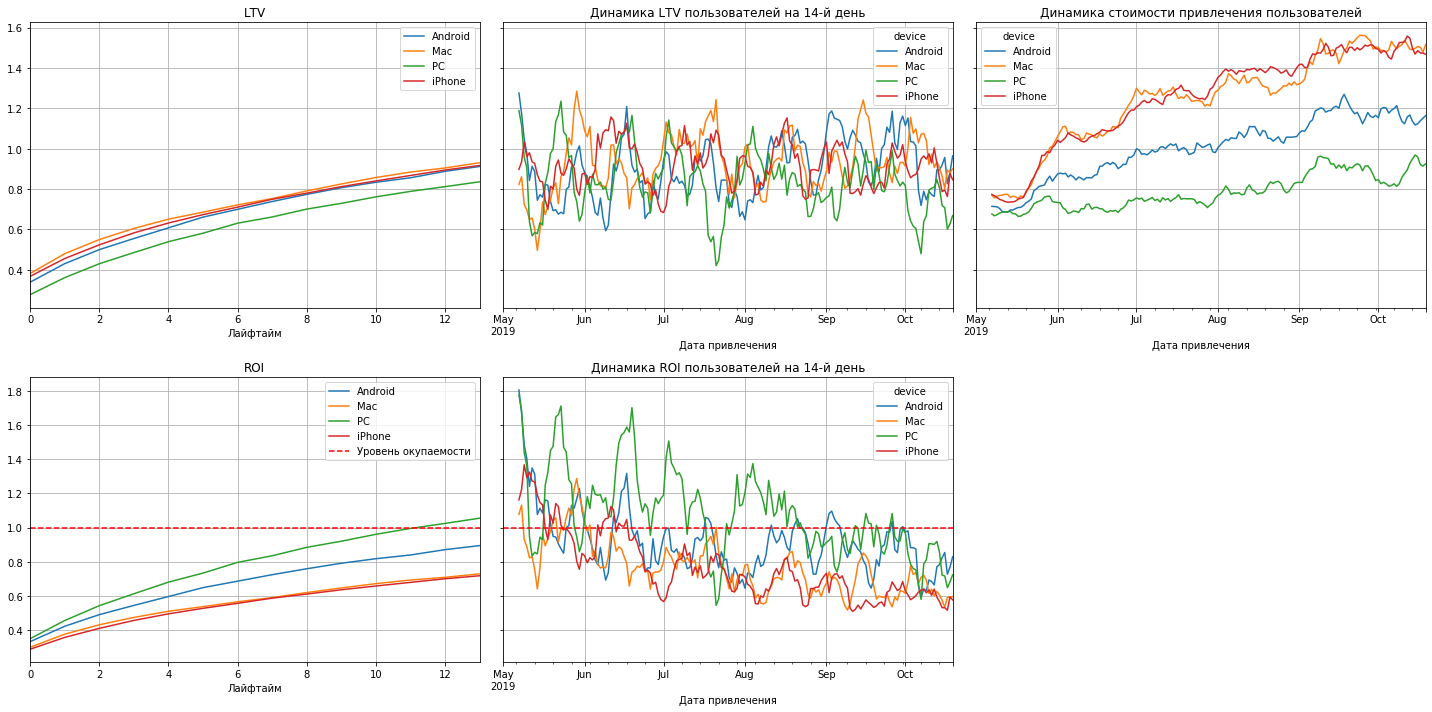

In [33]:
# Смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7) 

Видно, что окупаются только пользователи PC. Узнаем, в чем причина остальных платформ: в низкой конверсии или низком удержании:

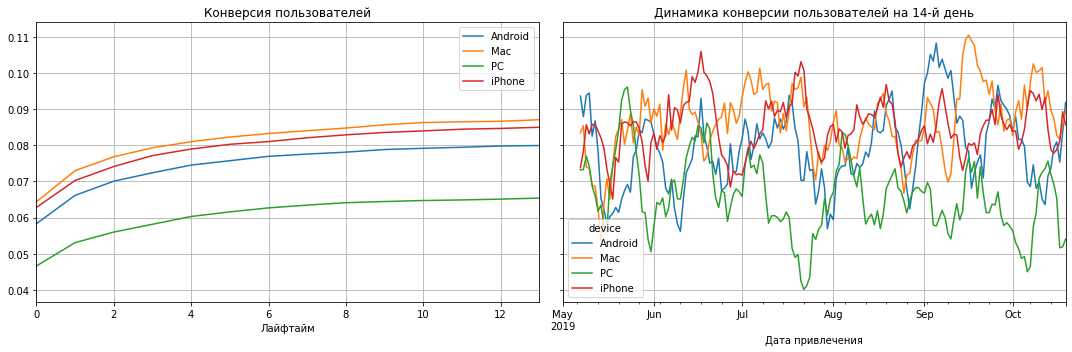

In [34]:
# Смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, пользователи проблемных платформ конвертируются хорошо, причём постоянно. Исследуем их удержание:

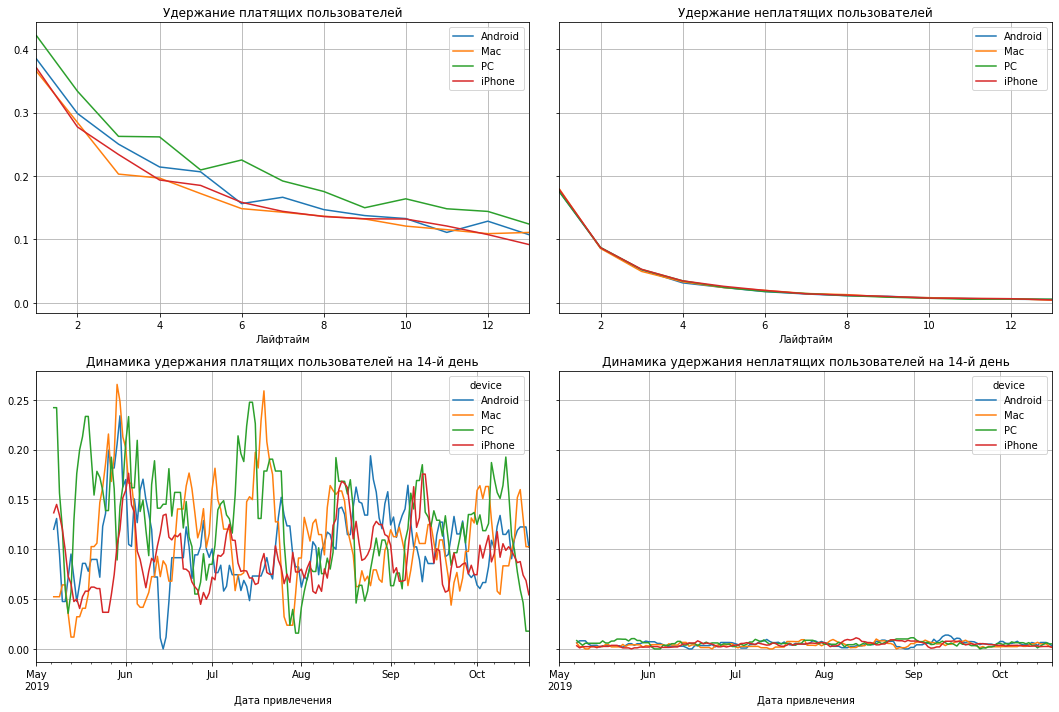

In [35]:
# Смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Проблем с удержанием тоже нет - оно не выбивается из общей картины. Скорее всего, проблема не связана с устройствами пользователей. Смотрим дальше.

### Проанализируйте окупаемость рекламы с разбивкой по странам

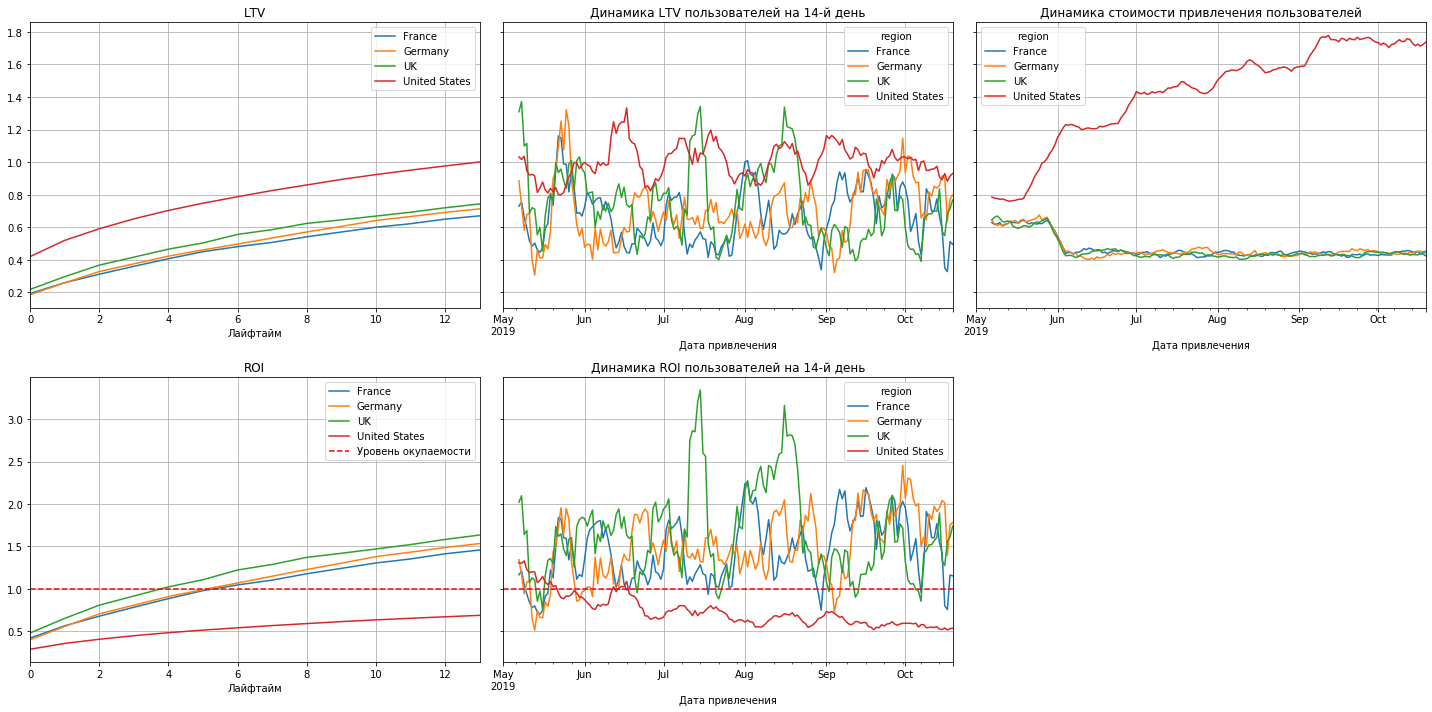

In [36]:
# Смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7) 

Видно, что реклама не окупается только в США. Также четко видно, что стоимость привлечения пользователей там сильно растет. Постараемся найти причину:

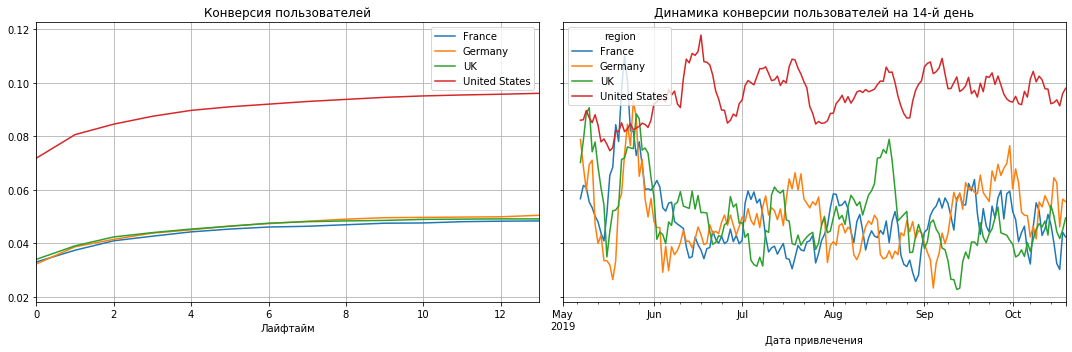

In [37]:
# Смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия пользователей из США значительно выше, чем у других стран. Смотрим их удержание:

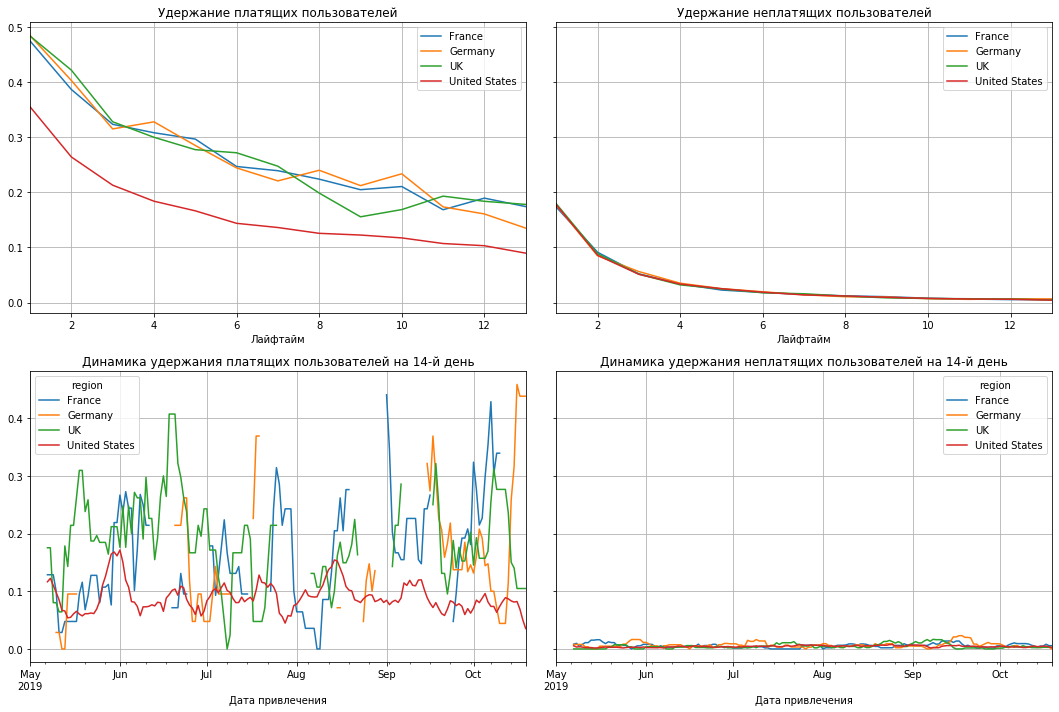

In [38]:
# Смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

А вот удержиются пользователи из США значительно хуже остальных.

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

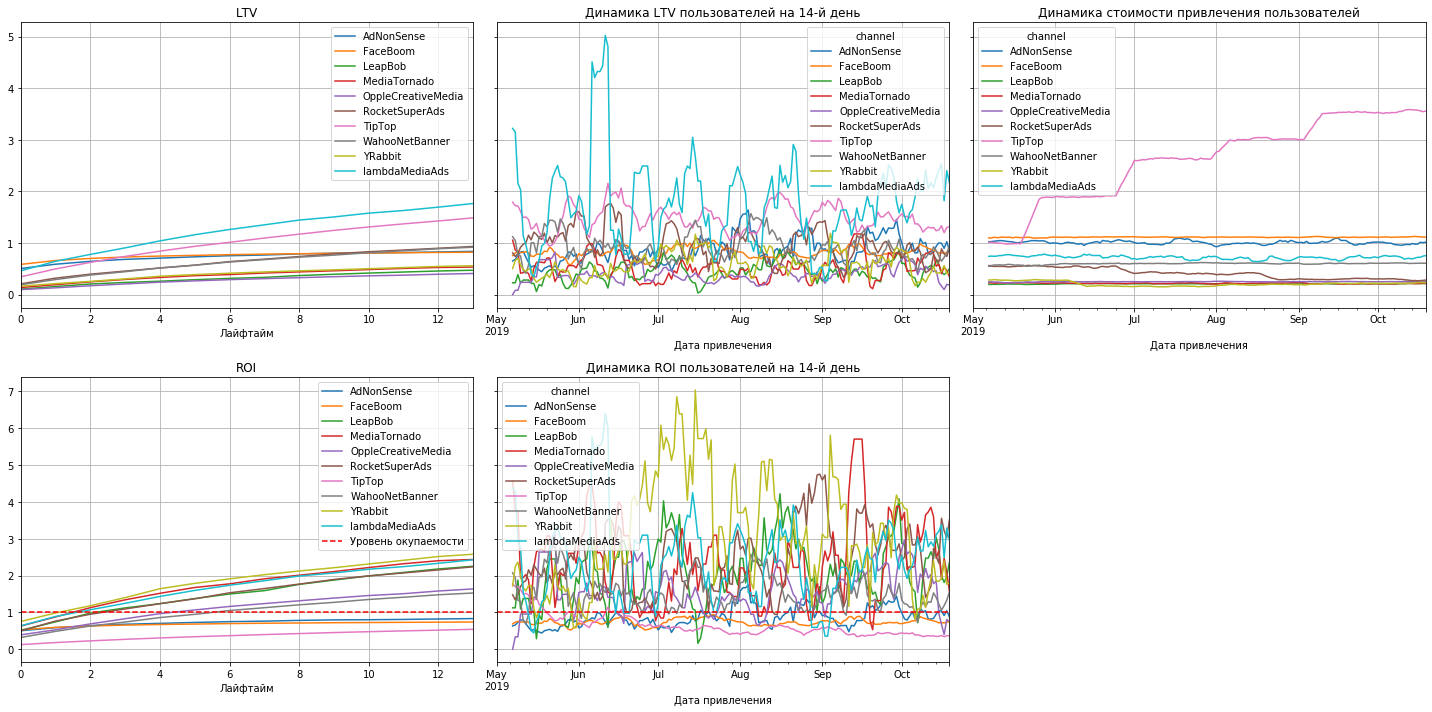

In [39]:
# Смотрим окупаемость с разбивкой по каналам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7) 

Стабильно не окупаются каналы TipTop, FaceBoom и AdNonSense. Смотрим конверсию и удержание:

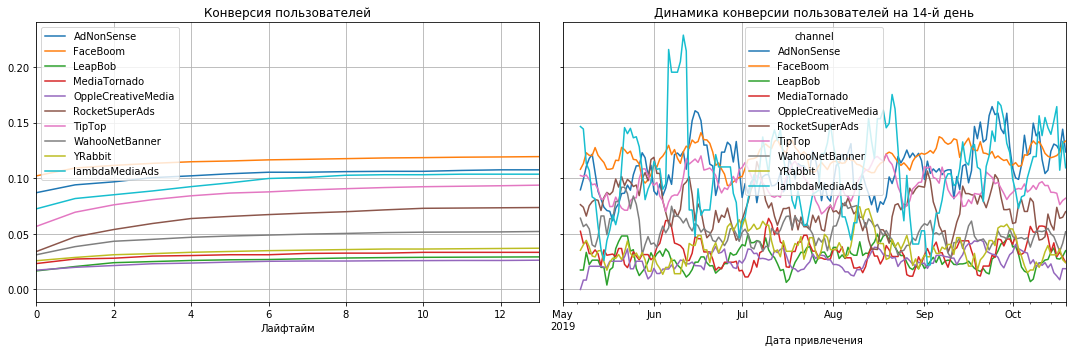

In [40]:
# Смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Пользователи из многих источников имеют довольно слабую конверсию.

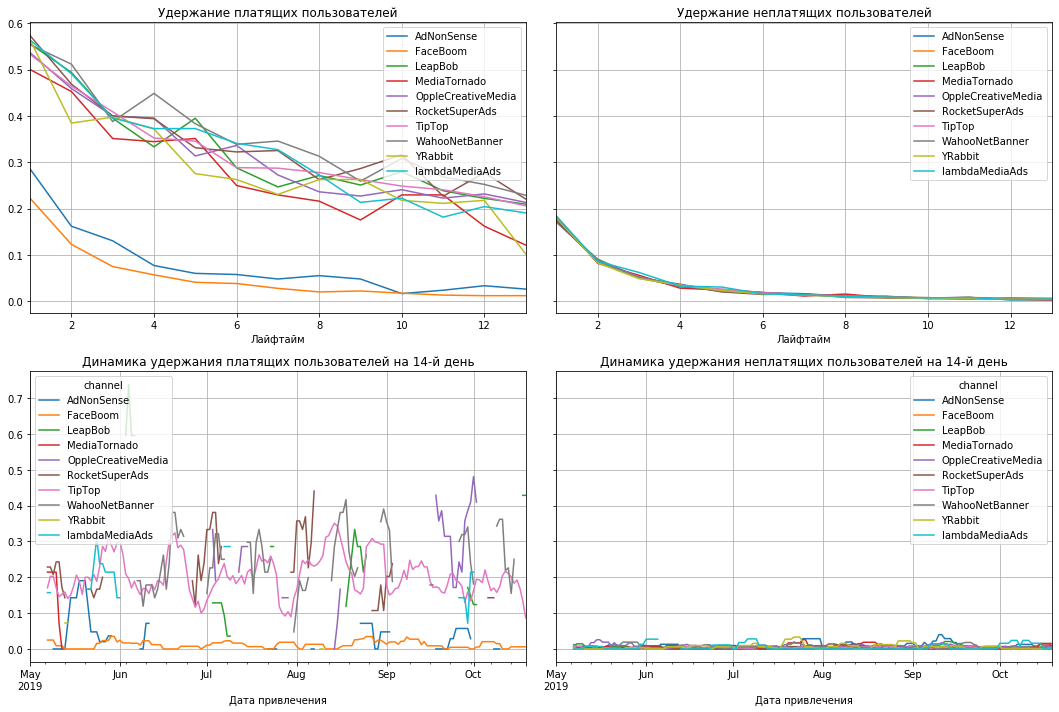

In [41]:
# Смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Пользователи, пришедшие из каналов AdNonSense и FaceBoom очень плохо удерживаются.

## Выводы
По итогам исследования можно выделить следующие **причины неэффективности** привлечения пользователей:
* Имеется проблема с привлечением клиентов из США. На исследуемом временном участке стоимость их привлечения значительно выросла, а время удержания платящих пользователей оттуда - значительно ниже показателей других стран;
* Пользователи, пришедшие из каналов AdNonSense и FaceBoom имеют самую высокую CAC и очень плохо удерживаются - делаем вывод, что оттуда приходит нецелевая аудитория;
* У канала TipTop на исследуемом промежутке значительно выросла стоимость привлечения пользователя. Видимо, канал стабильно повышал стоимость рекламы, а маркетинг соглашался с такими ценами;


Можно дать следующие **рекомендации** для отдела маркетинга для повышения эффективности:
* Либо отказаться от закупки трафика в каналах TipTop, AdNonSense и FaceBoom, либо значительно пересмотреть настройки рекламы;
* Реклама для США получается очень дорогой. Вероятно, стоит пересмотреть подход к продвижению продукта.